<a href="https://colab.research.google.com/github/harbidel/Mosquito-on-human-skin-prediction-model/blob/main/Mosquito%20on%20Human%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

In [2]:
!wget --no-check-certificate \
    "https://github.com/harbidel/Mosquito-on-human-skin-prediction-model/archive/refs/heads/main.zip" \
    -O "/tmp/mosquito.zip"


zip_ref = zipfile.ZipFile('/tmp/mosquito.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()


--2022-08-21 22:01:10--  https://github.com/harbidel/Mosquito-on-human-skin-prediction-model/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/harbidel/Mosquito-on-human-skin-prediction-model/zip/refs/heads/main [following]
--2022-08-21 22:01:11--  https://codeload.github.com/harbidel/Mosquito-on-human-skin-prediction-model/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/mosquito.zip’

/tmp/mosquito.zip       [             <=>    ] 111.06M  25.9MB/s    in 4.2s    

2022-08-21 22:01:15 (26.2 MB/s) - ‘/tmp/mosquito.zip’ saved [116450775]



In [3]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from tensorflow import keras
from keras import optimizers
%matplotlib inline
import math 
import datetime
import time

In [4]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'
# loading up our datasets
train_data_dir = '/tmp/Mosquito-on-human-skin-prediction-model-main/data_splitting/Train' 
validation_data_dir = '/tmp/Mosquito-on-human-skin-prediction-model-main/data_splitting/Pred' 
test_data_dir = '/tmp/Mosquito-on-human-skin-prediction-model-main/data_splitting/Test'
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

In [5]:
from tensorflow.keras import applications

#Loading vgc16 model
vgg16 = applications.vgg16.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

58900480/58889256 [==============================] - 0s 0us/step


In [6]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 4200 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Time:  0:00:35.583671


In [7]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 4200 images belonging to 6 classes.


In [9]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
val_generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_val_samples = len(val_generator.filenames) 
val_num_classes = len(val_generator.class_indices) 
 
predict_size_val = int(math.ceil(nb_val_samples / batch_size)) 
 
bottleneck_features_val = vgg16.predict_generator(val_generator, predict_size_val) 
 
np.save('bottleneck_features_val.npy', bottleneck_features_val)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3600 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Time:  0:00:20.286946


In [11]:
# Validation data
val_generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_val_samples = len(val_generator_top.filenames) 
val_num_classes = len(val_generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load('bottleneck_features_val.npy') 
 
# get the class labels for the training data, in the original order 
validation_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 3600 images belonging to 6 classes.


In [14]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=keras.optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])
history = model.fit(train_data, train_labels, 
   epochs=100,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/100
84/84 [==============================] - 2s 13ms/step - loss: 1.7370 - acc: 0.2702 - val_loss: 1.5103 - val_acc: 0.4244
Epoch 2/100
84/84 [==============================] - 1s 9ms/step - loss: 1.4721 - acc: 0.4048 - val_loss: 1.3165 - val_acc: 0.5383
Epoch 3/100
84/84 [==============================] - 1s 9ms/step - loss: 1.3316 - acc: 0.4860 - val_loss: 1.2734 - val_acc: 0.5061
Epoch 4/100
84/84 [==============================] - 1s 9ms/step - loss: 1.2135 - acc: 0.5364 - val_loss: 1.1116 - val_acc: 0.6025
Epoch 5/100
84/84 [==============================] - 1s 9ms/step - loss: 1.1223 - acc: 0.5702 - val_loss: 0.9967 - val_acc: 0.6289
Epoch 6/100
84/84 [==============================] - 1s 9ms/step - loss: 1.0395 - acc: 0.6190 - val_loss: 0.9178 - val_acc: 0.6664
Epoch 7/100
84/84 [==============================] - 1s 9ms/step - loss: 0.9788 - acc: 0.6321 - val_loss: 0.8435 - val_acc: 0.7122
Epoch 8/100
84/84 [==============================] - 1s 8ms/step - loss: 0.9296 - 

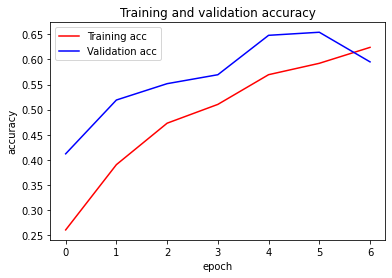

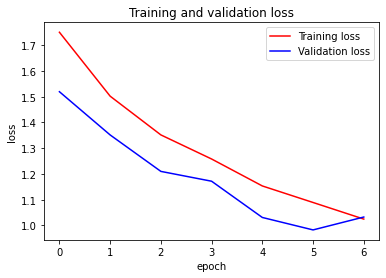

In [13]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()